In [1]:
import pandas as pd
import re
from pykospacing import Spacing

In [2]:
import os
os.getcwd()

'/Users/ryleyun/Desktop/Github/Ryles_Practice/Paperstudy'

train = open('../DATA/cnnpaper/ratings_train.txt', 'r')
train = train.readlines()
test = open('../DATA/cnnpaper/ratings_test.txt', 'r')
test = test.readlines()

train = [line.strip().split('\t') for line in train]
test = [line.strip().split('\t') for line in test]

train_df = pd.DataFrame(train[1:], columns=train[0])
test_df = pd.DataFrame(test[1:], columns=test[0])

spacing = Spacing()
train_df['document'] = [spacing(str(sent)) for sent in train_df['document']]
test_df['document'] = [spacing(str(sent)) for sent in test_df['document']]

train_df.to_csv('train_spacing.csv')
test_df.to_csv('test_spacing.csv')

In [3]:
train_df = pd.read_csv('../DATA/train_spacing.csv')
test_df = pd.read_csv('../DATA/test_spacing.csv')

In [4]:
from konlpy.tag import Mecab
mecab = Mecab()

In [5]:
%%time
def pos(x):
    try:
        text = ''
        for word, pos in mecab.pos(str(x)):
            if pos[0] not in ['J','I','E']:
                if type(re.search("\W+|[0-9]", word))!=re.Match: 
                    # and len(word)!=1:
                    text+=" "+word
        return text.strip()
    
    except:
        pass

train_df["pos"] = train_df["document"].apply(pos)
test_df["pos"] = test_df["document"].apply(pos)

CPU times: user 12.8 s, sys: 171 ms, total: 13 s
Wall time: 14.1 s


In [6]:
vocab_size = [] 

for line in train_df['pos']:
    vocab_size.extend(str(line).split())
len(set(vocab_size))

46941

(array([3.0141e+04, 1.3184e+04, 3.5000e+03, 1.8090e+03, 1.2780e+03,
        8.4000e+01, 3.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0. ,  10.5,  21. ,  31.5,  42. ,  52.5,  63. ,  73.5,  84. ,
         94.5, 105. ]),
 <BarContainer object of 10 artists>)

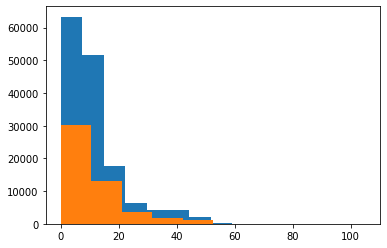

In [7]:
train_length = [len(str(line).split()) for line in train_df['pos']]
test_length = [len(str(line).split()) for line in test_df['pos']]

import matplotlib.pyplot as plt
plt.hist(train_length)
plt.hist(test_length)

In [14]:
# tokenizing
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(train_df['pos'])
word_index = tokenizer.word_index

# padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = tokenizer.texts_to_sequences(train_df['pos'])
test_seq = tokenizer.texts_to_sequences(test_df['pos'])
train_pad = pad_sequences(train_seq, maxlen=40, padding='pre', truncating='pre')
test_pad = pad_sequences(test_seq, maxlen=40, padding='pre', truncating='pre')

In [15]:
test_pad.shape

(50000, 40)

In [41]:
embedding_dim = 20
max_length = 40
vocab_size = len(set(word_index))+1

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Flatten, Dropout
from tensorflow.keras import layers, models

model = Sequential()
# Embedding layer? Input 값이 처음으로 들어오는 layer
# vocab_size는 데이터 셋 내의 유니크 단어 수, embedding_dim은 몇 차원으로 줄일 것인지, input_length는 들어오는 문장의 최대 길이
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(layers.Conv1D(128, 3, activation='relu', padding='Same'))
# model.add(Dropout(0.5))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(256, 3, activation='relu', padding='Same'))
# model.add(Dropout(0.5))
model.add(layers.MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 40, 20)            928480    
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 40, 128)           7808      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 20, 128)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 20, 256)           98560     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 10, 256)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)              

In [42]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(train_pad, train_df['label'].astype('int32'), epochs=3, batch_size=500, validation_split=0.1, verbose=2)

Epoch 1/3
270/270 - 21s - loss: 0.6193 - accuracy: 0.6091 - val_loss: 0.3828 - val_accuracy: 0.8295
Epoch 2/3
270/270 - 19s - loss: 0.3817 - accuracy: 0.8429 - val_loss: 0.3443 - val_accuracy: 0.8469
Epoch 3/3
270/270 - 19s - loss: 0.3135 - accuracy: 0.8777 - val_loss: 0.3481 - val_accuracy: 0.8534


In [43]:
pred = model.predict(test_pad)

In [44]:
result = []
for i in pred:
    if i>=0.5:
        result.append(1)
    else:
        result.append(0)

In [45]:
print(f"{ round(sum(result==test_df['label'])/len(test_df)*100, 4) }%")

84.882%
